In [196]:
import h5py, os, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import classification_report
from collections import Counter

In [14]:
model_path = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir, 'models'))
test_image_path = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir, os.path.pardir, os.path.pardir, 'VOC_PCB', 'JPEGImages'))
downloads_path = os.path.join(os.path.expanduser('~'),"Downloads")

In [19]:
model = load_model(os.path.join(model_path, 'model_enhanced_res_unet-v240618_1.keras'))
history = pd.read_csv(os.path.join(model_path, 'model_enhanced_res_unet-v240618_1.csv'))
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   classification_output_accuracy               14 non-null     float64
 1   classification_output_precision              14 non-null     float64
 2   classification_output_recall                 14 non-null     float64
 3   loss                                         14 non-null     float64
 4   segmentation_output_accuracy                 14 non-null     float64
 5   segmentation_output_mean_absolute_error      14 non-null     float64
 6   segmentation_output_mean_io_u                14 non-null     float64
 7   val_classification_output_accuracy           14 non-null     float64
 8   val_classification_output_precision          14 non-null     float64
 9   val_classification_output_recall             14 non-null     float64
 10  val_

In [20]:
train_loss = history["loss"]
val_loss = history["val_loss"]

train_acc_class = history["classification_output_accuracy"]
val_acc_class = history["val_classification_output_accuracy"]

train_acc_seg = history["segmentation_output_accuracy"]
val_acc_seg = history["val_segmentation_output_accuracy"]

train_meanIOU = history["segmentation_output_mean_io_u"]
val_meanIOU = history["val_segmentation_output_mean_io_u"]

train_mae_seg = history["segmentation_output_mean_absolute_error"]
val_mae_seg = history["val_segmentation_output_mean_absolute_error"]

train_precision_class = history["classification_output_precision"]
val_precision_class = history["val_classification_output_precision"]

train_recall_class = history["classification_output_recall"]
val_recall_class = history["val_classification_output_recall"]

def calculate_f1_score(precision, recall, epsilon=1e-9):
    return 2* (precision * recall) / (precision + recall + epsilon)

train_F1_score = [calculate_f1_score(precision, recall) for precision, recall in zip(train_precision_class, train_recall_class)]
val_F1_score = [calculate_f1_score(precision, recall) for precision, recall in zip(val_precision_class, val_recall_class)]


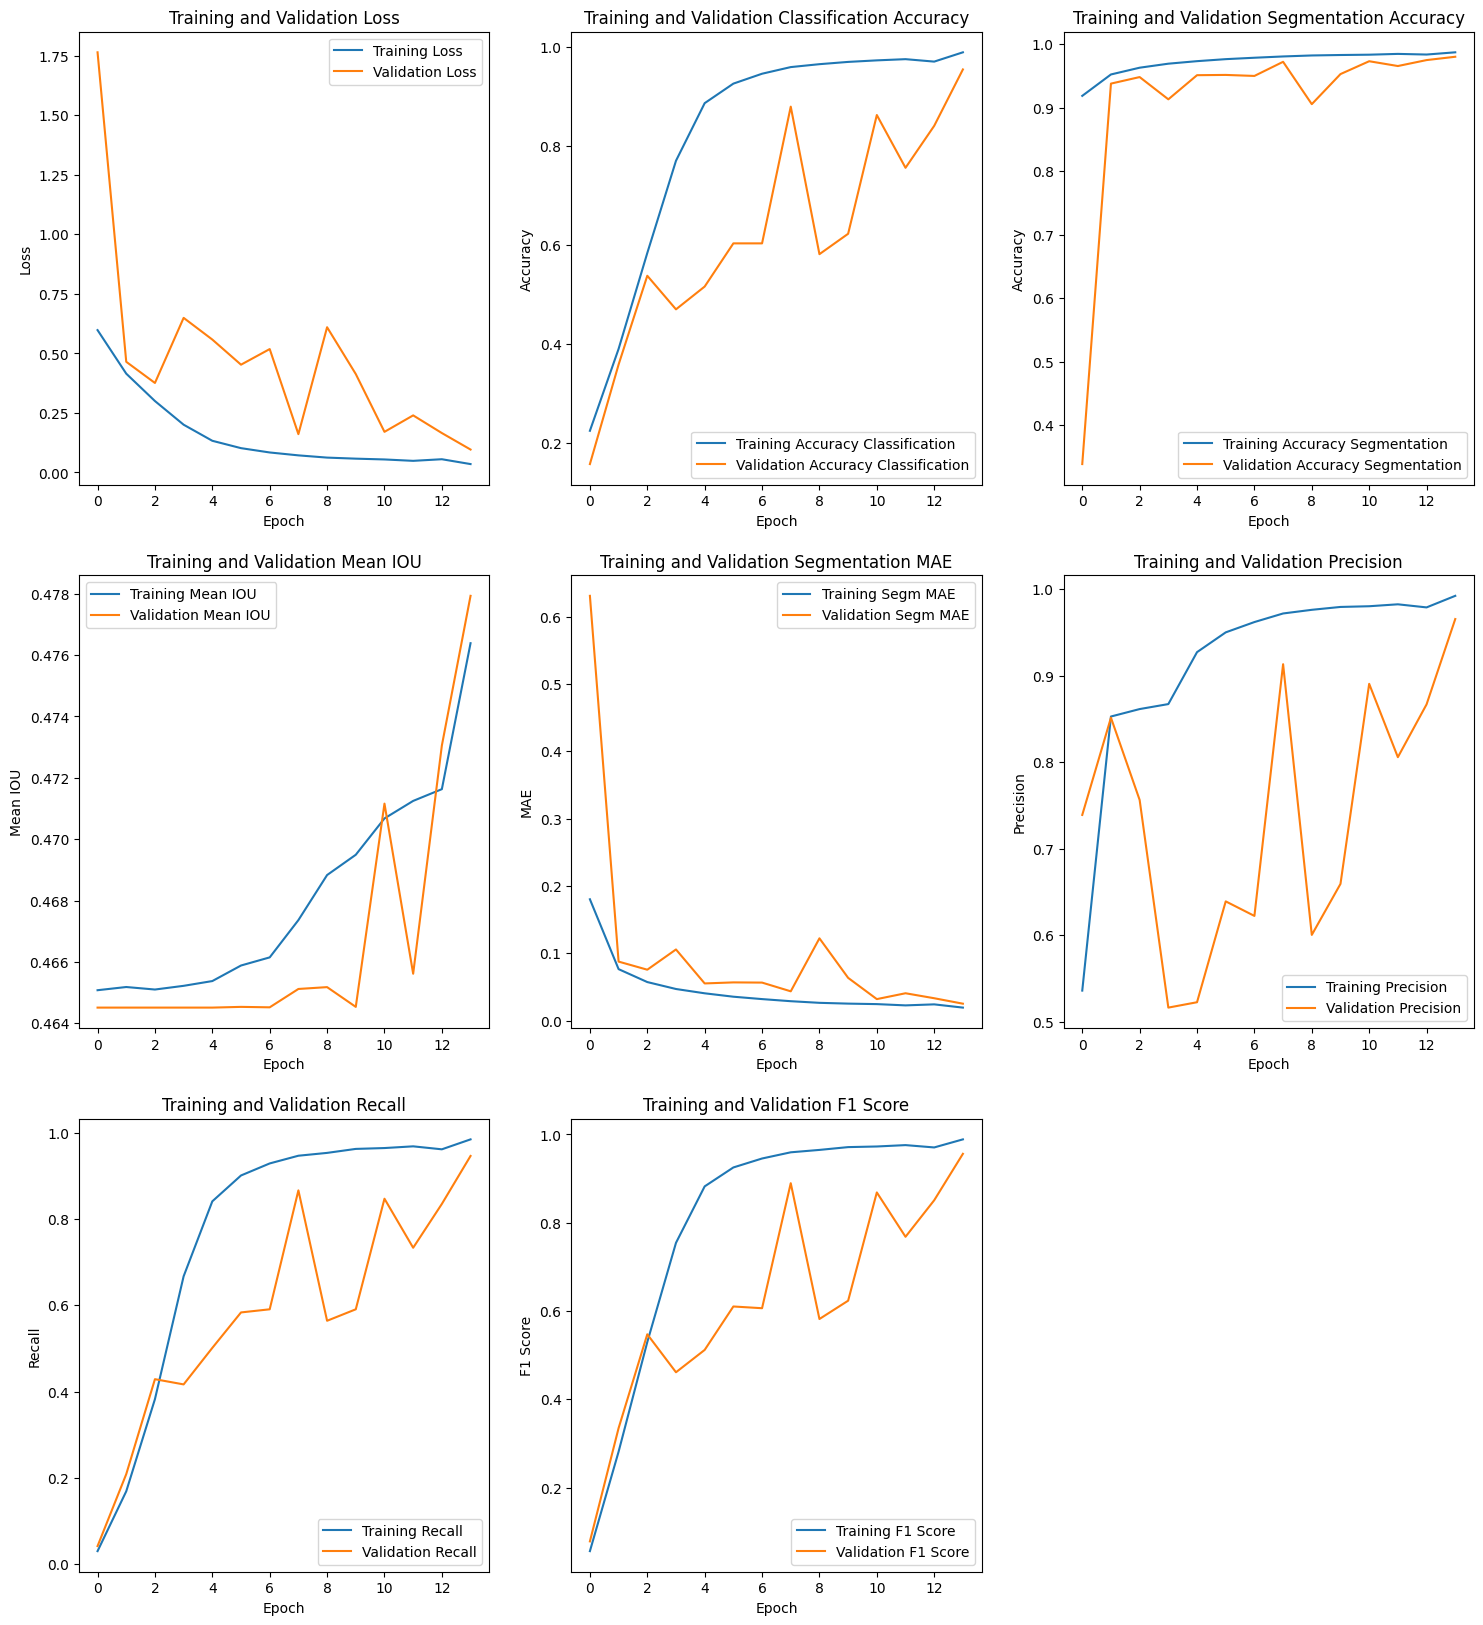

In [21]:

plt.figure(figsize = (18,20))

plt.subplot(3, 3, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(3, 3, 2)
plt.plot(train_acc_class, label="Training Accuracy Classification")
plt.plot(val_acc_class, label="Validation Accuracy Classification")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Classification Accuracy")
plt.legend()

plt.subplot(3, 3, 3)
plt.plot(train_acc_seg, label="Training Accuracy Segmentation")
plt.plot(val_acc_seg, label="Validation Accuracy Segmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Segmentation Accuracy")
plt.legend()

plt.subplot(3, 3, 4)
plt.plot(train_meanIOU, label="Training Mean IOU")
plt.plot(val_meanIOU, label="Validation Mean IOU")
plt.xlabel("Epoch")
plt.ylabel("Mean IOU")
plt.title("Training and Validation Mean IOU")
plt.legend()

plt.subplot(3, 3, 5)
plt.plot(train_mae_seg, label="Training Segm MAE")
plt.plot(val_mae_seg, label="Validation Segm MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training and Validation Segmentation MAE")
plt.legend()

plt.subplot(3, 3, 6)
plt.plot(train_precision_class, label="Training Precision")
plt.plot(val_precision_class, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()

plt.subplot(3, 3, 7)
plt.plot(train_recall_class, label="Training Recall")
plt.plot(val_recall_class, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()

plt.subplot(3, 3, 8)
plt.plot(train_F1_score, label="Training F1 Score")
plt.plot(val_F1_score, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()

#plt.tight_layout()
plt.show()

In [22]:
# Step 1: Open the HDF5 file
file_name = 'test_data.h5'
file_path = os.path.join(downloads_path, file_name)
with h5py.File(file_path, 'r') as hdf:
    # Step 2: List all groups
    print(f"Keys: {hdf.keys()}")
    # Get the name of the dataset you want to read
    dataset_names = list(hdf.keys())

    # Step 3: Extract the dataset
    X_test = np.asarray(hdf[dataset_names[0]])
    y_test_class_cat = np.asarray(hdf[dataset_names[1]])
    y_test_mask = np.asarray(hdf[dataset_names[2]])

    #print(type(X_test))

    # Step 4: Read the data into a NumPy array
    #X_test = dataset[:]

# Step 5: Use the data
X_test = np.expand_dims(X_test, axis=3)

print(X_test.shape)
print(y_test_mask.shape)
print(y_test_class_cat.shape)


Keys: <KeysViewHDF5 ['X', 'y_class_cat', 'y_mask']>
(413, 100, 100, 1)
(413, 100, 100)
(413, 7)


In [23]:
y_pred_mask, y_pred_class_cat = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


In [24]:
labels = ['missing hole',
          'mouse_bite',
          'none',
          'open circuit',
          'short',
          'spur',
          'spurious copper']
y_test_class = np.asarray(list(map(lambda cat: labels[np.argmax(cat)], y_test_class_cat)))
y_pred_class = np.asarray(list(map(lambda cat: labels[np.argmax(cat)], y_pred_class_cat)))
y_pred_confidence = np.asarray(list(map(lambda cat: np.max(cat), y_pred_class_cat)))


In [25]:
print(classification_report(y_test_class, y_pred_class))

                 precision    recall  f1-score   support

   missing hole       1.00      0.98      0.99        65
     mouse_bite       1.00      0.93      0.96        55
           none       0.85      0.92      0.88        65
   open circuit       0.94      0.98      0.96        59
          short       1.00      0.98      0.99        57
           spur       0.97      0.92      0.94        65
spurious copper       0.96      0.96      0.96        47

       accuracy                           0.95       413
      macro avg       0.96      0.95      0.96       413
   weighted avg       0.96      0.95      0.95       413



In [ ]:
rnd = np.random.choice(X_test.shape[0], 20)
for i in range(rnd.shape[0]):
    confidence = y_pred_confidence[rnd[i]]
    fig, ax = plt.subplots(1, 3, figsize=(8,5))
    ax[0].imshow(X_test[rnd[i]].squeeze(), cmap='gray')
    ax[0].set_title('original test image')
    ax[0].set_axis_off()
    ax[1].imshow(y_test_mask[rnd[i]].squeeze(), cmap='gray')
    ax[1].set_title(f'original test mask:\n {y_test_class[rnd[i]]}')
    ax[2].imshow(y_pred_mask[rnd[i]].squeeze(), cmap='gray')
    ax[2].set_title(f'predicted mask:\n {y_pred_class[rnd[i]]} ({confidence:.5f})');

    

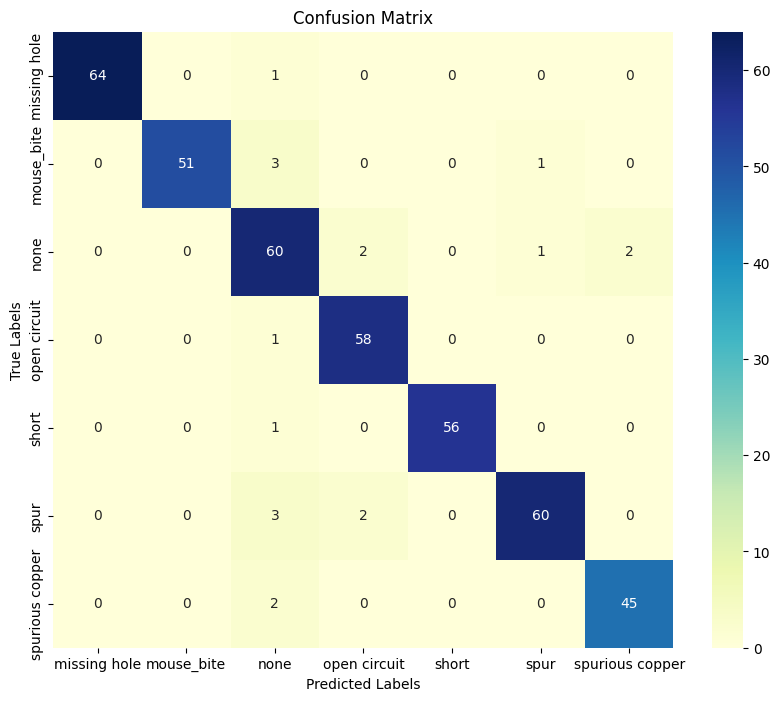

In [30]:
crosstab = pd.crosstab(y_test_class, y_pred_class)
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
missing_hole_indices = np.where(y_pred_class == 'missing hole')[0]# Get the indices directly
# Get the corresponding predicted masks for missing_hole predictions
missing_hole_masks = y_pred_mask[missing_hole_indices]
missing_hole_labels = np.array(y_pred_class)[missing_hole_indices]
print(len(missing_hole_indices))
print(missing_hole_indices)


## Print the predicted masks  
#for i in range(len(missing_hole_indices)):
#    plt.imshow(missing_hole_masks[i].squeeze(), cmap='gray') 
#    plt.title('Original Test mask: \n' + missing_hole_labels[i])
#    plt.axis('off')
#    
#    plt.show()

64
[ 10  12  22  26  32  40  41  49  55  56  57  64  67  71  76  88  92  96
 104 107 109 118 122 128 135 138 150 159 172 185 198 201 214 216 230 231
 235 240 241 256 262 267 269 287 288 292 301 302 303 307 326 327 332 337
 338 340 348 349 351 355 373 377 403 410]


## Testing with single 600x600 images

### Definitions of needed functions

In [172]:
def load_test_image(image_name):
    try:
        image = cv2.imread(os.path.join(test_image_path, image_name))
        image = cv2.resize(image, (600, 600)) 
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_array = np.asarray(image_gray) / 255.0 
        image_array = np.expand_dims(image_array, axis=2) # add channel dimension
        plt.imshow(image_array, cmap='gray')
        plt.axis('off');
        return image_array
    except:
        print(f"Image {image_name} not found in {test_image_path}")

In [180]:
def crop_image(image, crop_size=(100, 100)):
    crops = []
    height, width = image.shape
    crop_height, crop_width = crop_size

    for i in range(0, height, crop_height):
        for j in range(0, width, crop_width):
            crop = image[i:i + crop_height, j:j + crop_width]
            if crop.shape[0] == crop_height and crop.shape[1] == crop_width:
                crops.append(crop)
    return crops



In [227]:
def combine_crops(crops, crop_size=(100, 100), full_size=(600, 600)):
    rows = full_size[0] // crop_size[0]
    cols = full_size[1] // crop_size[1]
    combined_image = np.zeros(full_size)

    crop_idx = 0
    for i in range(rows):
        for j in range(cols):
            combined_image[i*crop_size[0]:(i+1)*crop_size[0], j*crop_size[1]:(j+1)*crop_size[1]] = crops[crop_idx]
            crop_idx += 1
    return combined_image

### testing the model on single 600x600 images from the image pool

#### First image (missing hole)

(1, 600, 600, 1)


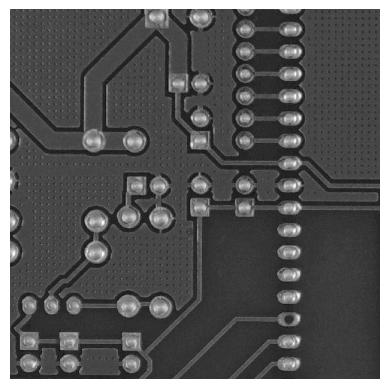

In [173]:
test_image_1 = load_test_image('l_light_01_missing_hole_17_3_600.jpg')
test_image_1 = np.expand_dims(test_image_1, axis=0) # add batch dimension
print(test_image_1.shape)

In [174]:
y_pred_mask_1, y_pred_class_cat_1 = model.predict(test_image_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [175]:
print(y_pred_class_cat_1)
y_pred_class_1 = labels[np.argmax(y_pred_class_cat_1)]
print(f"Predicted Label: {y_pred_class_1} ({np.max(y_pred_class_cat_1)})")

[[1.2823581e-07 3.9028077e-08 9.9999833e-01 5.0559214e-07 3.4961578e-09
  9.3965588e-07 6.2532493e-08]]
Predicted Label: none (0.9999983310699463)


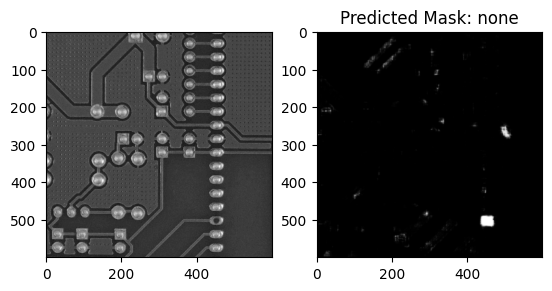

In [146]:
plt.subplot(121) 
plt.imshow(test_image_array_1.squeeze(), cmap='gray')

plt.subplot(122) 
plt.imshow(y_pred_mask_1.squeeze(), cmap='gray')
plt.title(f"Predicted Mask: {y_pred_class_1}")
plt.show()

#### Second image (spur)

(1, 600, 600, 1)


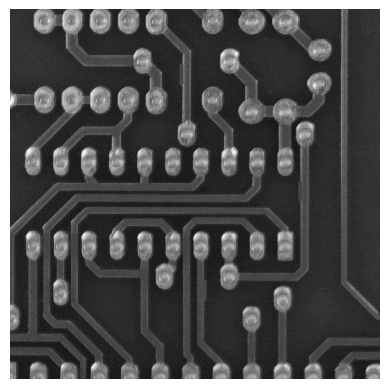

In [176]:
test_image_2 = load_test_image('l_light_11_spur_02_5_600.jpg')
test_image_2 = np.expand_dims(test_image_2, axis=0)
print(test_image_2.shape)

In [185]:
# Crop the normalized grayscale image into 100x100 sections
crops = np.asarray(crop_image(test_image_2.squeeze(), crop_size=(100, 100)))
crops = np.expand_dims(crops, axis=-1)

In [186]:
#print(X_test.shape)
print(crops.shape)

(36, 100, 100, 1)


In [189]:
y_pred_mask_2, y_pred_class_cat_2 = model.predict(crops)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step


In [192]:
y_pred_class_cat_2.shape

(36, 7)

In [194]:
print(y_pred_class_cat_2)
y_pred_class_2 = [labels[np.argmax(row)] for row in y_pred_class_cat_2]
print(f"Predicted Labels: {y_pred_class_2}")

[[5.71714656e-04 1.85996993e-03 9.93287027e-01 8.02260824e-04
  2.00220908e-04 3.00228153e-03 2.76617793e-04]
 [7.08195940e-03 1.41953798e-02 7.77973235e-01 4.19699885e-02
  2.48112017e-03 1.25847682e-01 3.04506123e-02]
 [4.32180660e-03 4.92486879e-02 4.84739125e-01 1.11516900e-01
  2.23898282e-03 3.18013728e-01 2.99208127e-02]
 [1.86109019e-03 6.26014452e-03 9.25595820e-01 4.90972325e-02
  3.12440097e-04 1.03748003e-02 6.49843598e-03]
 [3.19636753e-03 1.63562573e-03 8.87027681e-01 4.70750146e-02
  2.56178144e-04 9.94638167e-03 5.08627295e-02]
 [2.56400032e-04 3.39479069e-04 9.96789694e-01 2.01496505e-03
  4.78283109e-05 3.12059768e-04 2.39590823e-04]
 [3.31916427e-03 2.14602193e-03 9.78207588e-01 4.95239999e-03
  6.36890938e-04 6.07760390e-03 4.66033118e-03]
 [6.02173153e-03 2.77941930e-03 9.78926837e-01 3.96102760e-03
  1.62797910e-03 5.25696063e-03 1.42606301e-03]
 [6.59532333e-03 1.94009878e-02 8.40979576e-01 5.89807220e-02
  1.90105068e-03 3.75626311e-02 3.45797502e-02]
 [1.809976

In [235]:
defects = [label for label in y_pred_class_2 if label != 'none']

label_counts = Counter(defects)

# Find the label with the maximum count
most_common_label = label_counts.most_common(1)[0][0]

# Print the count of each label
print(f"Label Counts: {label_counts.most_common()}")

# Print the label with the highest count
print(f"Label with highest count: {most_common_label}")

Label Counts: [('spur', 2)]
Label with highest count: spur


In [ ]:
for i in range(36):

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.imshow(crops[i], cmap='gray')
    plt.title('Original Test Image')
    plt.axis('off')


    plt.subplot(122)
    plt.imshow(y_pred_mask_2[i], cmap='gray')
    plt.title(f'Predicted Mask \n Predicted Label: {y_pred_class_2[i]}')
    plt.axis('off')

    plt.show()

In [240]:
X_test_2_recombined = combine_crops(crops.squeeze())

y_pred_mask_2_recombined = combine_crops(y_pred_mask_2.squeeze())

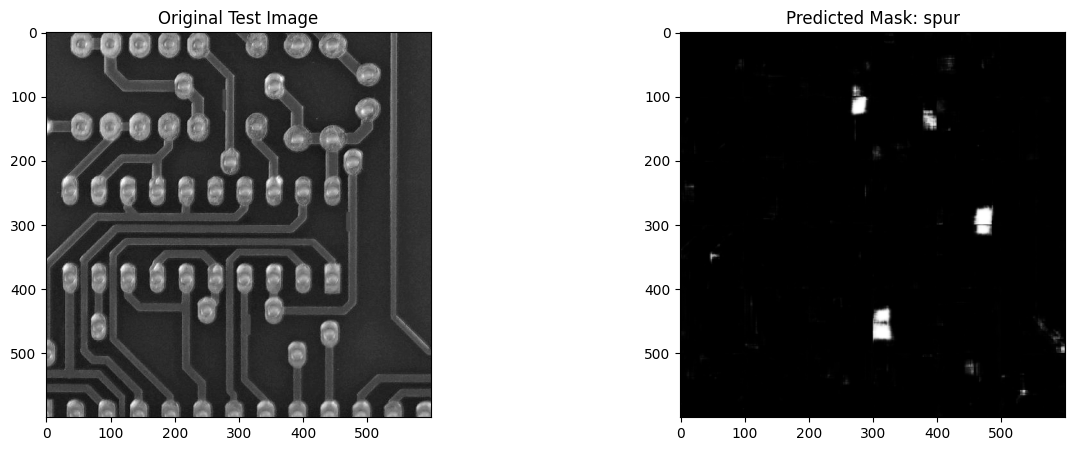

In [241]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(X_test_2_recombined, cmap='gray')
plt.title('Original Test Image')
#plt.axis('off')


plt.subplot(122)
plt.imshow(y_pred_mask_2_recombined, cmap='gray')
plt.title(f'Predicted Mask: {most_common_label}')
#plt.axis('off')

plt.show()

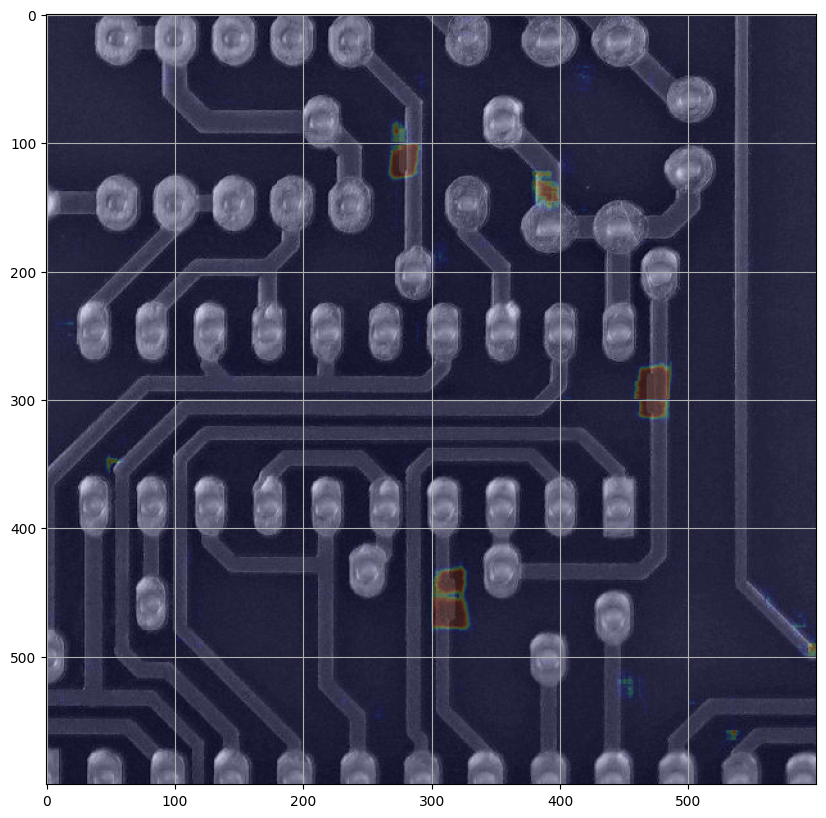

In [319]:
plt.figure(figsize=(10,10))

plt.imshow(X_test_2_recombined, cmap='gray')
plt.imshow(y_pred_mask_2_recombined, alpha=.2, cmap='jet')
plt.grid(visible=True, axis='both')


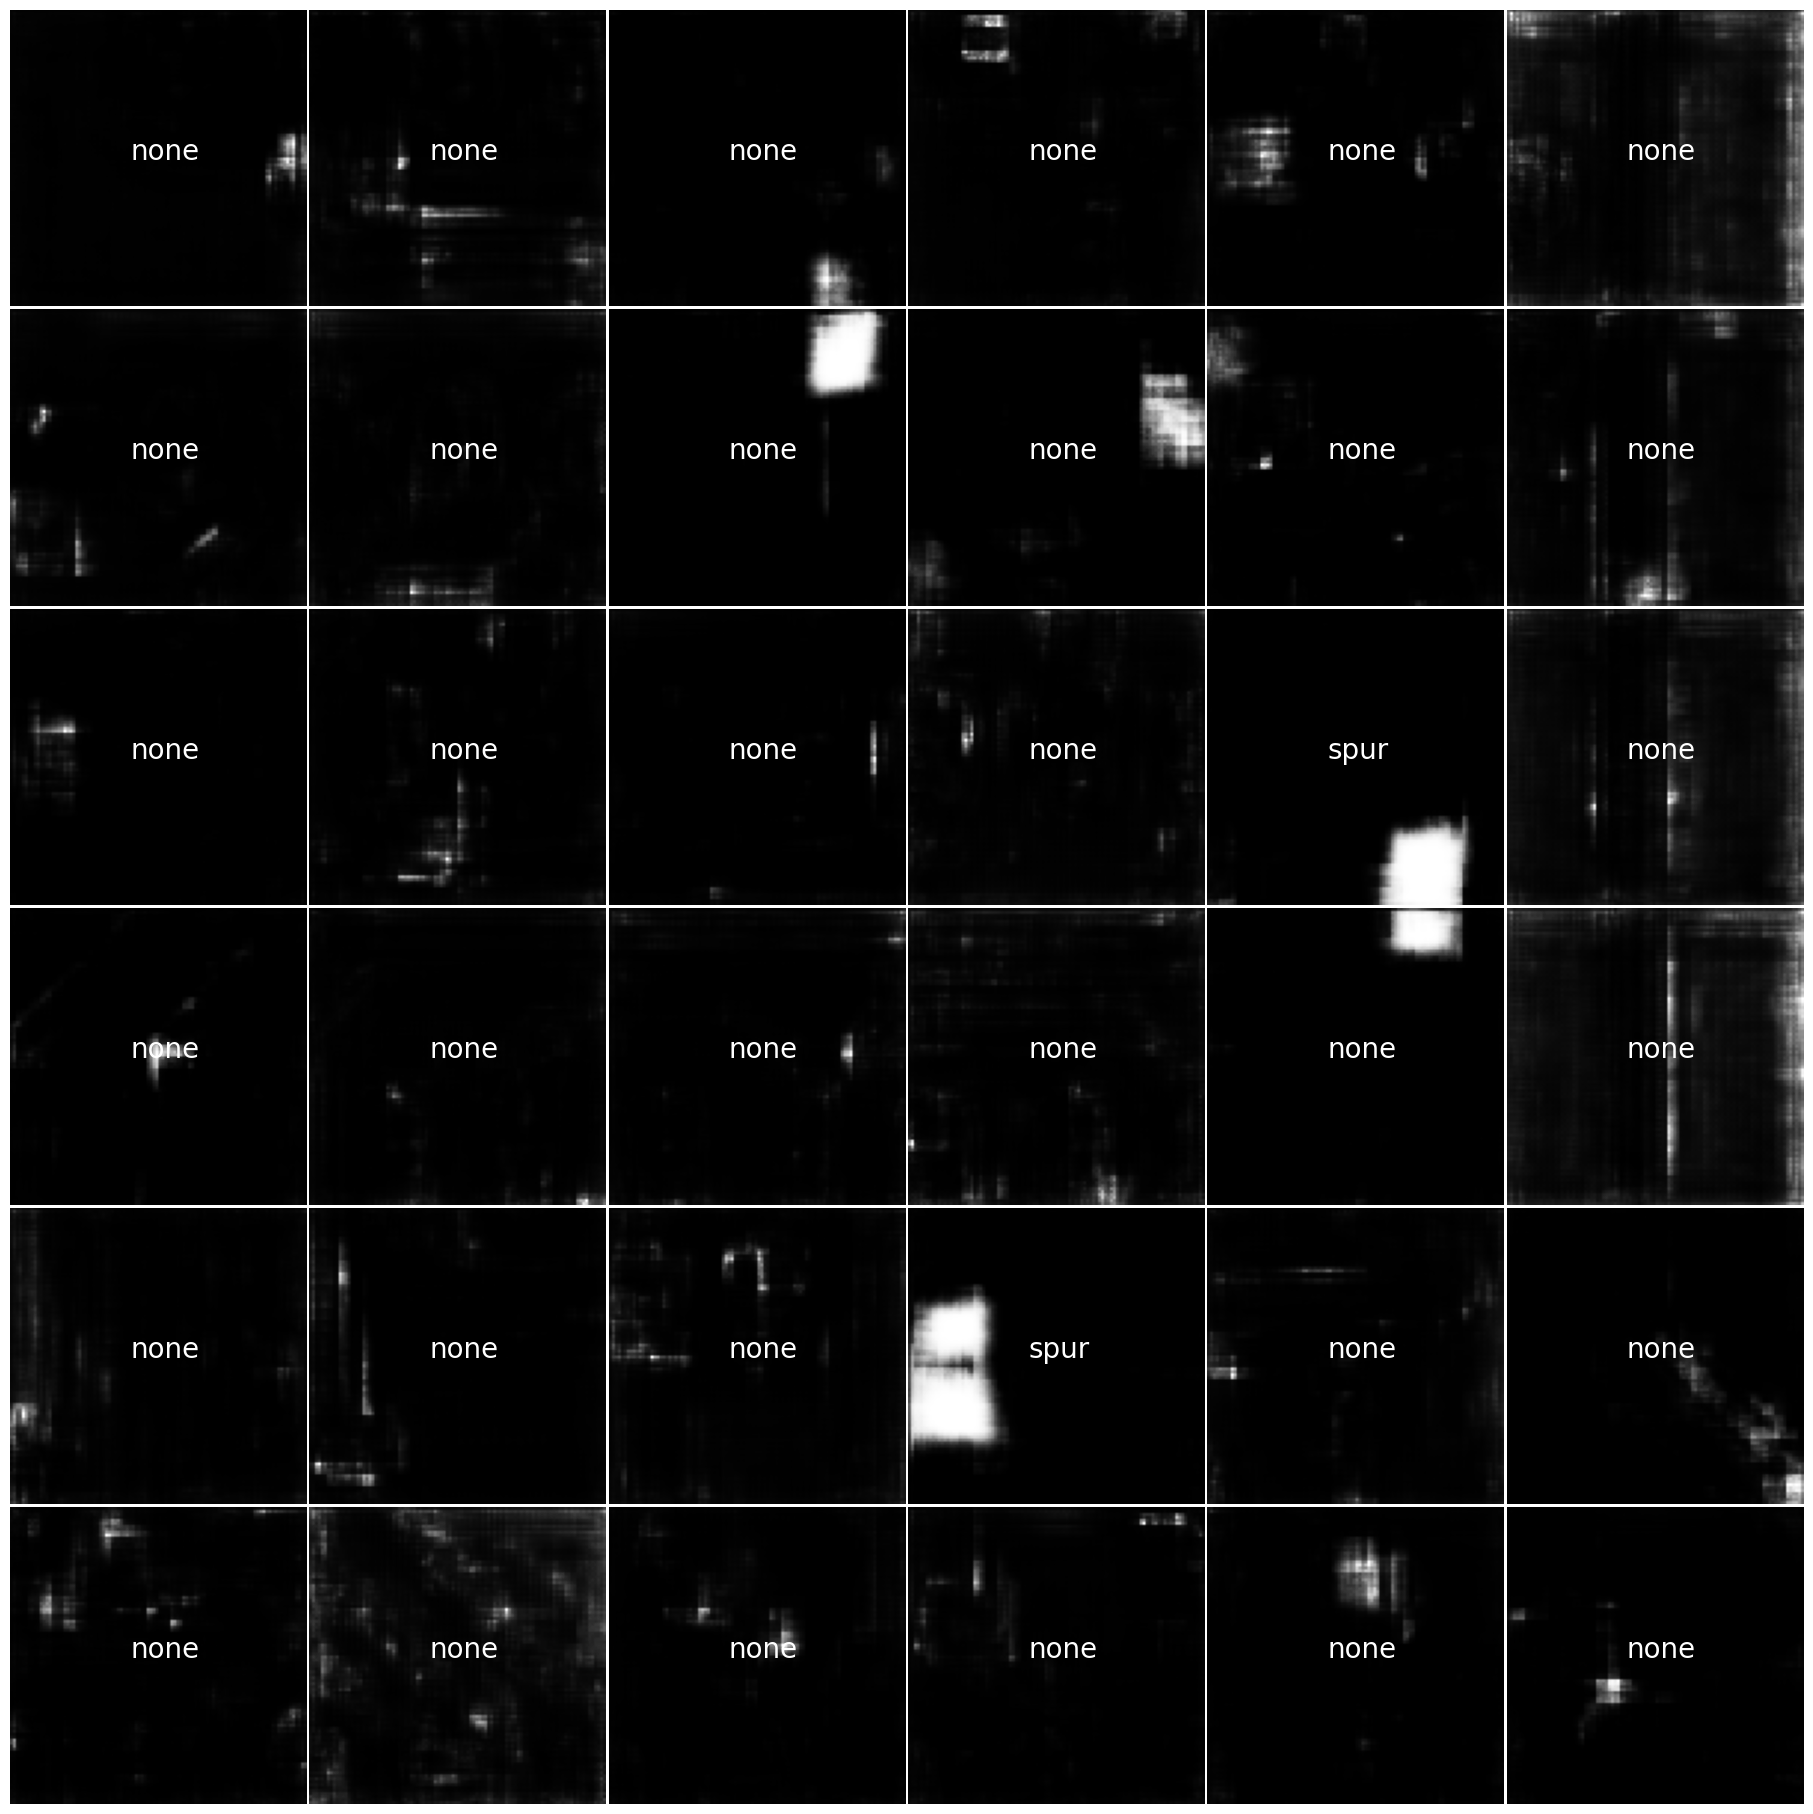

In [320]:
y_pred_combined = list(zip(y_pred_mask_2, y_pred_class_2))

fig, ax = plt.subplots(6, 6, figsize=(18,18))
ax = ax.flatten()
for idx, (img, label) in enumerate(y_pred_combined):
    ax[idx].imshow(img, cmap='gray')
    ax[idx].annotate(xy=(50,50), xytext=(40,50), text=label, color='white', fontsize=20)
    ax[idx].axis('off')
fig.tight_layout(pad=.2)
